# Исследование надежности заемщиков

Кредитным отделом банка предоставлена статистика о платёжеспособности клиентов. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

<font size=+1><b>Данные</b></font><br>
Данные с заёмщиками credit_project.csv
- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел задолженность по возврату кредитов (`1`), не имел задолжности (`0`)
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

<font size=+1><b>План работы:</b></font><br>
- Загрузить и изучить данные
- Найти и изучить пропуски в данных
- Выделить важную информацию: 
    - категорию заёмщика по его зарплате
    - категорию цели кредита
- Выделить и обработать аномалии в данных
- Выявить зависимость между возвратом кредита в срок и:
    - количеством детей
    - семейным положением
    - уровнем дохода
    - влияние целей кредита
- Написать общий вывод

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
plt.rc('figure', figsize=(20, 8))

In [3]:
# функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset, sep=',')
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient('coolwarm'))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    print('--------------')
    display('Гистограммы:')
    data.hist(figsize=(20, 8))
    plt.show();
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для создания сводной таблицы с долей пропусков
def table_pass(data, col_group):
    df = data.groupby(by='income_type', as_index=False)\
             .agg(total = ('income_type', 'count'),
                  median = (col_group, 'median'),
                  fill = (col_group, 'count'))\
             .sort_values(by='total', ascending=False) 
    df['share_pass'] = (df['total'] - df['fill']) / df['total']
    df = df.loc[:, ['income_type', 'total', 'median', 'share_pass']]
    return df.style.format({'median': '{:.1f}','share_pass': '{:.1%}'})\
             .background_gradient('Blues')

In [6]:
# функция для построения графиков
def bar_plot(data, values_x):
    return data.plot(x=values_x,
                     kind='bar',
                     legend=False)

In [7]:
# функция для категоризации дохода
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'G'
        elif 30001 <= income <= 50000:
            return 'F'
        elif 50001 <= income <= 100000:
            return 'E'
        elif 100001 <= income <= 200000:
            return 'D'
        elif 200001 <= income <= 400000:
            return 'C'
        elif 400001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [8]:
# функция для категоризации причины кредита
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [9]:
# функция для должников
def debt(data, category):
    df = data.groupby(by=category, as_index=False, observed=False)\
             .agg(total_credit = ('debt', 'count'),
                  total_debt = ('debt', 'sum'),
                  share_debt = ('debt', 'mean'))  
    return df.style.format({'share_debt': '{:.1%}'})\
             .background_gradient(cmap='Blues', axis=0)

### Загрузка данных и основная информация

Посмотрим на основную информацию из таблицы:

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

,0
days_employed,10.1%
total_income,10.1%
children,0.0%
dob_years,0.0%
education,0.0%
education_id,0.0%
family_status,0.0%
family_status_id,0.0%
gender,0.0%
income_type,0.0%


---------------------------------


'Основная информация по таблице:'

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.0,19351.0,21525.0,21525.0,21525.0,21525.0,19351.0
mean,0.5,63046.5,43.3,0.8,1.0,0.1,167422.3
std,1.4,140827.3,12.6,0.5,1.4,0.3,102971.6
min,-1.0,-18388.9,0.0,0.0,0.0,0.0,20667.3
25%,0.0,-2747.4,33.0,1.0,0.0,0.0,103053.2
50%,0.0,-1203.4,42.0,1.0,0.0,0.0,145017.9
75%,1.0,-291.1,53.0,1.0,1.0,0.0,203435.1
max,20.0,401755.4,75.0,4.0,4.0,1.0,2265604.0


----------------------------------------


'Количество явных дубликатов в таблице:'

54

--------------


'Гистограммы:'

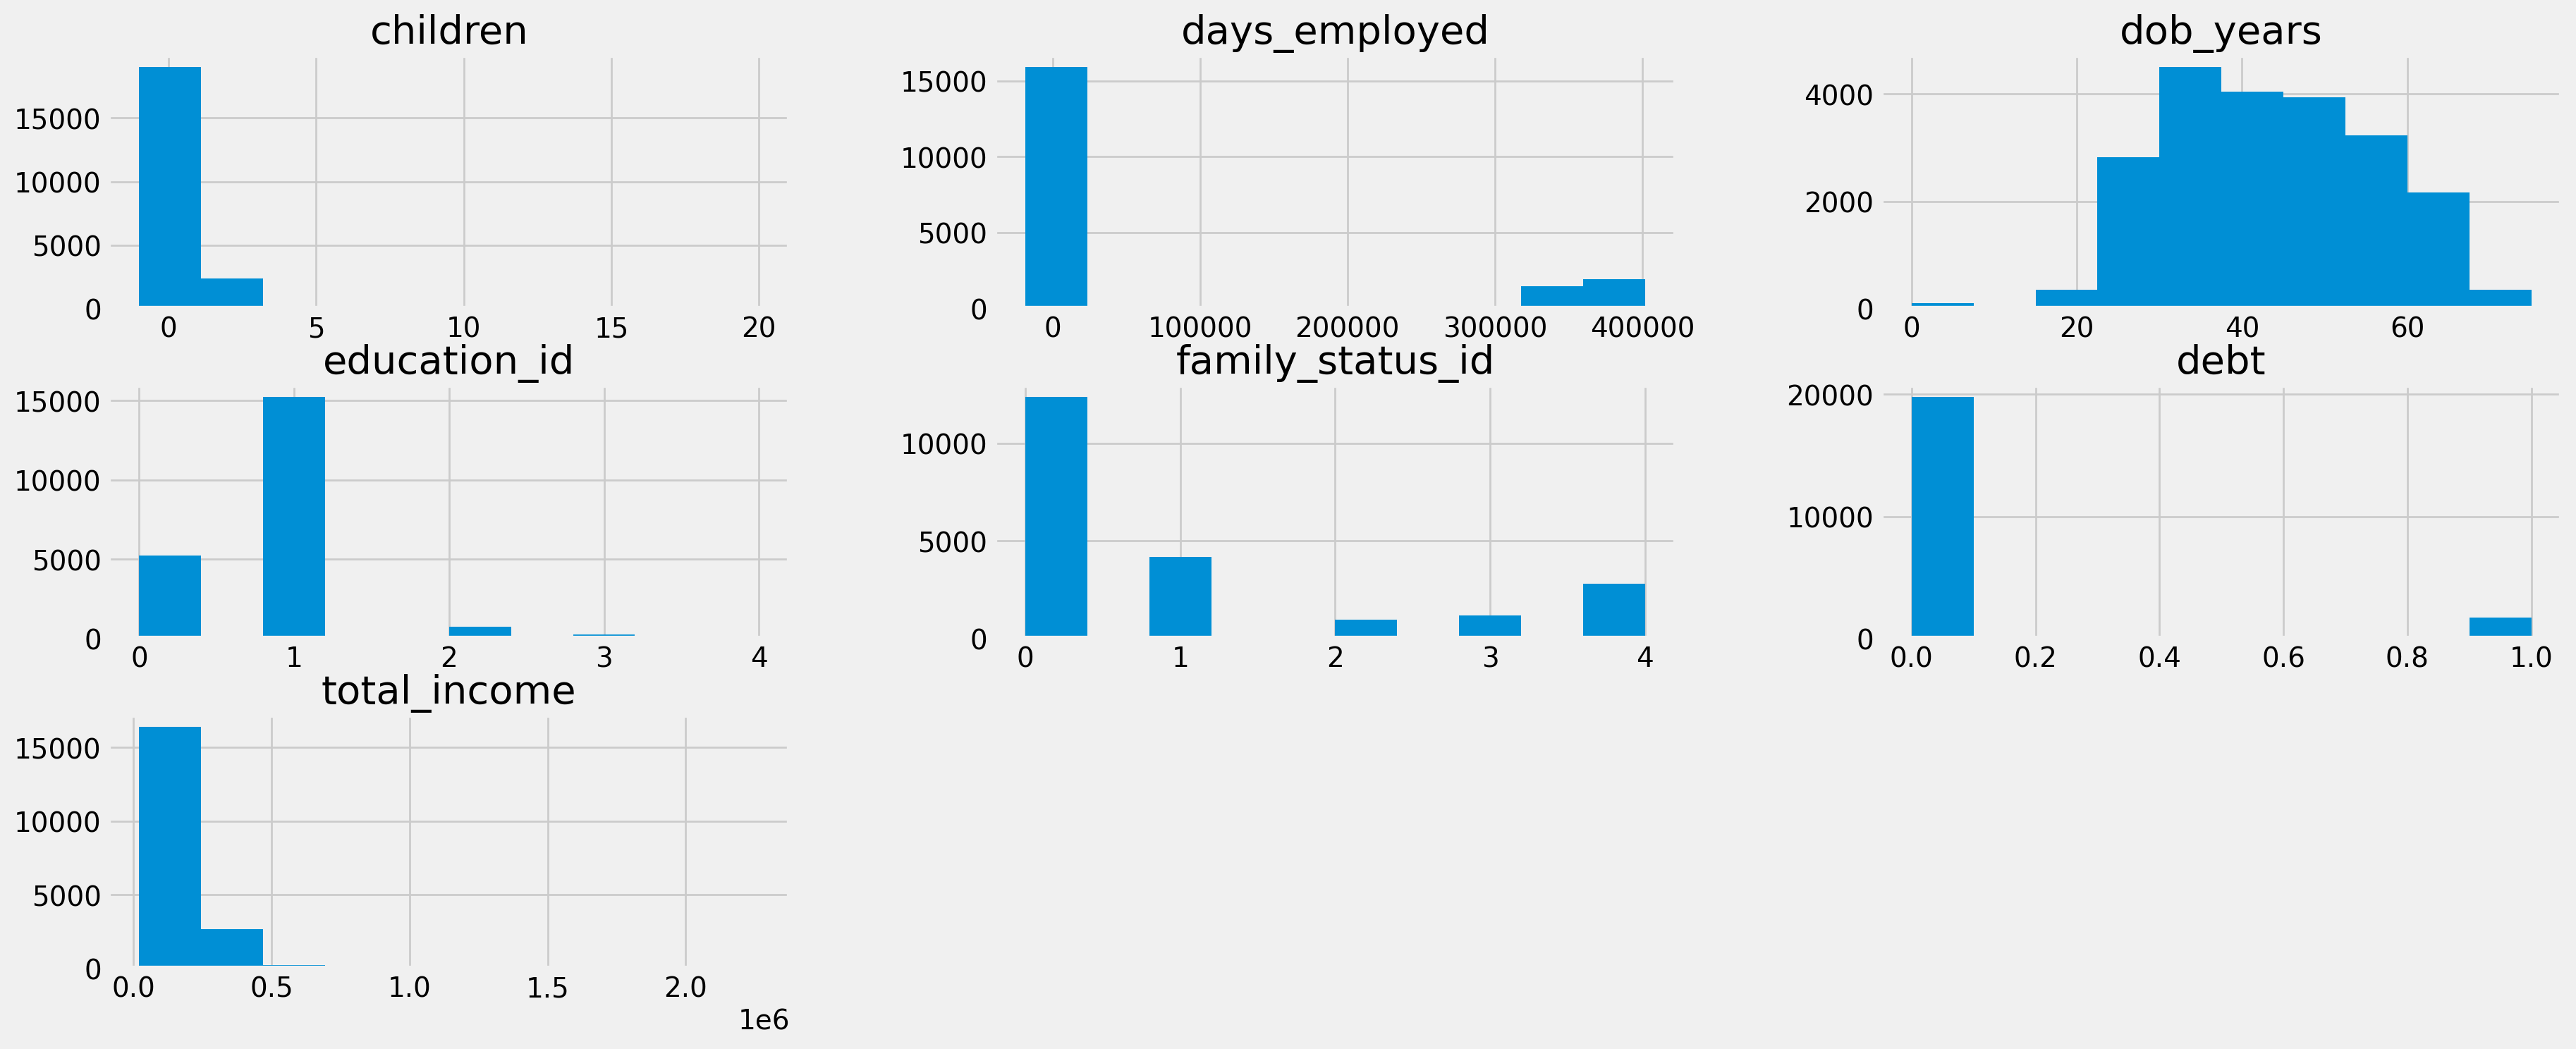

In [10]:
credit = main_info('credit_project.csv')

### Промежуточные выводы:

- В таблице 11 столбцов и 21525 записей с информацией о заёмщиках.
- В двух столбцах есть пропуски значений.
- Доля пропусков занимает 10% от общего количества строк в датафрейме.
- В столбце с общим трудовым стажем есть значения меньше нуля.
- В некоторых столбцах присуствуют аномалии или выбросы:
    - минимальное количество детей -1
    - максимальное количество детей 20
    - отрицательные значения в столбце с трудовым стажем
    - слишком большое std и максимальное значение в столбце с трудовым стажем
- В таблице есть 54 явных дубликата.
- В основном, заёмщики имеют до четырёх детей.
- Возраст клиента от 20 до 70.
- В основном клиенты не имеют задолжности по кредиту.
- В основном заём берут до 500 тыс рублей.

## Предобработка данных

### Обработка пропусков

#### Сумма дохода

In [11]:
# Переменная для контроля % удалённых значений
del_value = [0, credit.shape[0]]

В таблице в двух столбцах есть пропуски данных: дни трудового стажа и доходы. Пропуски значений могут означать, что заёмщик не предоставил такую информацию о себе, либо был какой-то сбой в данных (в столбцах с трудовым стажем были странные аномалии, такие как отрицательный стаж и нереалистично большие значения).

Обработаем пропуски в столбце с суммой дохода. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце можно медианным значением по каждому типу. Посмотрим, какое количество заёмщиков находится по каждой из категории и сколько пропусков в каждой категории.

In [12]:
table_pass(credit, 'total_income')

,income_type,total,median,share_pass
6,сотрудник,11119,142594.4,9.9%
3,компаньон,5085,172358.0,10.0%
4,пенсионер,3856,118514.5,10.7%
2,госслужащий,1459,150447.9,10.1%
0,безработный,2,131339.8,0.0%
5,предприниматель,2,499163.1,50.0%
1,в декрете,1,53829.1,0.0%
7,студент,1,98201.6,0.0%


В таблице представлено 7 типов занятости заёмщиков. При этом, безработных, предпринимателей, в декрете и студентов крайне мало, по 1-2 заёмщика в каждой категории. А для предпринимателя есть ещё и 1 пропуск данных. Для остальных категорий, где есть пропуски, эти пропуски составляют не более 11%. 

Для суммы дохода аномалий не видно, так что можно заполнить пропуски медианным значением в зависимости от категории занятости. 

In [13]:
for t in credit['income_type'].unique():
    credit.loc[(credit['income_type'] == t) & (credit['total_income'].isna()), 'total_income'] = \
    credit.loc[(credit['income_type'] == t), 'total_income'].median()

#### Трудовой стаж

Также пропуски были в стобце с днями занятости. Ещё в этом столбце присутствовали такие аномалии, как отрицательное количество дней трудового стажа. Заменим их на положительные значения.

In [14]:
credit['days_employed'] = credit['days_employed'].abs()

Посмотрим, зависит ли трудовой стаж от категории занятости и сколько пропущенных значений находится по каждому типу занятости.

In [15]:
table_pass(credit, 'days_employed')

,income_type,total,median,share_pass
6,сотрудник,11119,1574.2,9.9%
3,компаньон,5085,1547.4,10.0%
4,пенсионер,3856,365213.3,10.7%
2,госслужащий,1459,2689.4,10.1%
0,безработный,2,366413.7,0.0%
5,предприниматель,2,520.8,50.0%
1,в декрете,1,3296.8,0.0%
7,студент,1,578.8,0.0%


Для двух категорий: безработные и пенсионеры присутствуют аномалии - нереалистично большие значения трудового стажа, для всех остальных категорий данные смотрятся реалистично. При этом, категория пенсионеров достаточно большая - почти 3500 заёмщиков. Эти значения, не отражают действительности и появились по какой-то ошибке. Так как нет возможности уточнить, откуда возникла такая ошибка, оставим такие аномалии в данных.

Также можно отметить, что для предпринимателя есть 1 пропуск из двух значений. Для четырёх категорий с пропусками в трудовом стаже пропуски составляют не более 11%, их можно заполнить медианным значением для каждой категории.

In [16]:
for t in credit['income_type'].unique():
    credit.loc[(credit['income_type'] == t) & (credit['days_employed'].isna()), 'days_employed'] = \
    credit.loc[(credit['income_type'] == t), 'days_employed'].median()

Проверим, что все пропуски были обработаны:

In [17]:
credit.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

#### Промежуточные выводы:

- В столбце с суммой дохода было 10.1% пропусков. 
- В столбце с суммой дохода пропуски были заменены на медианные значения для каждой категории занятости заёмщиков.
- В столбце с трудовым стажем аномальные отрицательные значения были заменены на положительные.
- Аномалии были для двух категорий - безработных и пенсионеров. Аномалии были оставлены.
- В столбце с трудовым стажем было 10.1% пропусков. 
- Пропуски в столбце с трудовым стажем были заменены на медианные значения для каждой категории занятости заёмщиков.

### Обработка аномальных значений

#### Количество детей

Посмотрим на уникальные значения количества детей.

In [18]:
credit['children'].sort_values().unique()

array([-1,  0,  1,  2,  3,  4,  5, 20])

В столбце с количеством детей присутствуют два аномальных значения: -1 и 20. Такие строки можно удалить.

In [19]:
print('Процент данных с аномальным значением количества детей: ', 
      "{0:.1%}".format(credit.query('children == -1 | children == 20')\
                       ['children'].count() / credit.shape[0]))

Процент данных с аномальным значением количества детей:  0.6%


In [20]:
credit = credit.query('children != -1 & children != 20').reset_index(drop=True)
del_value[0] = credit.shape[0]

#### Возраст клиента

Посмотрим на гистограммы для возраста клиента.

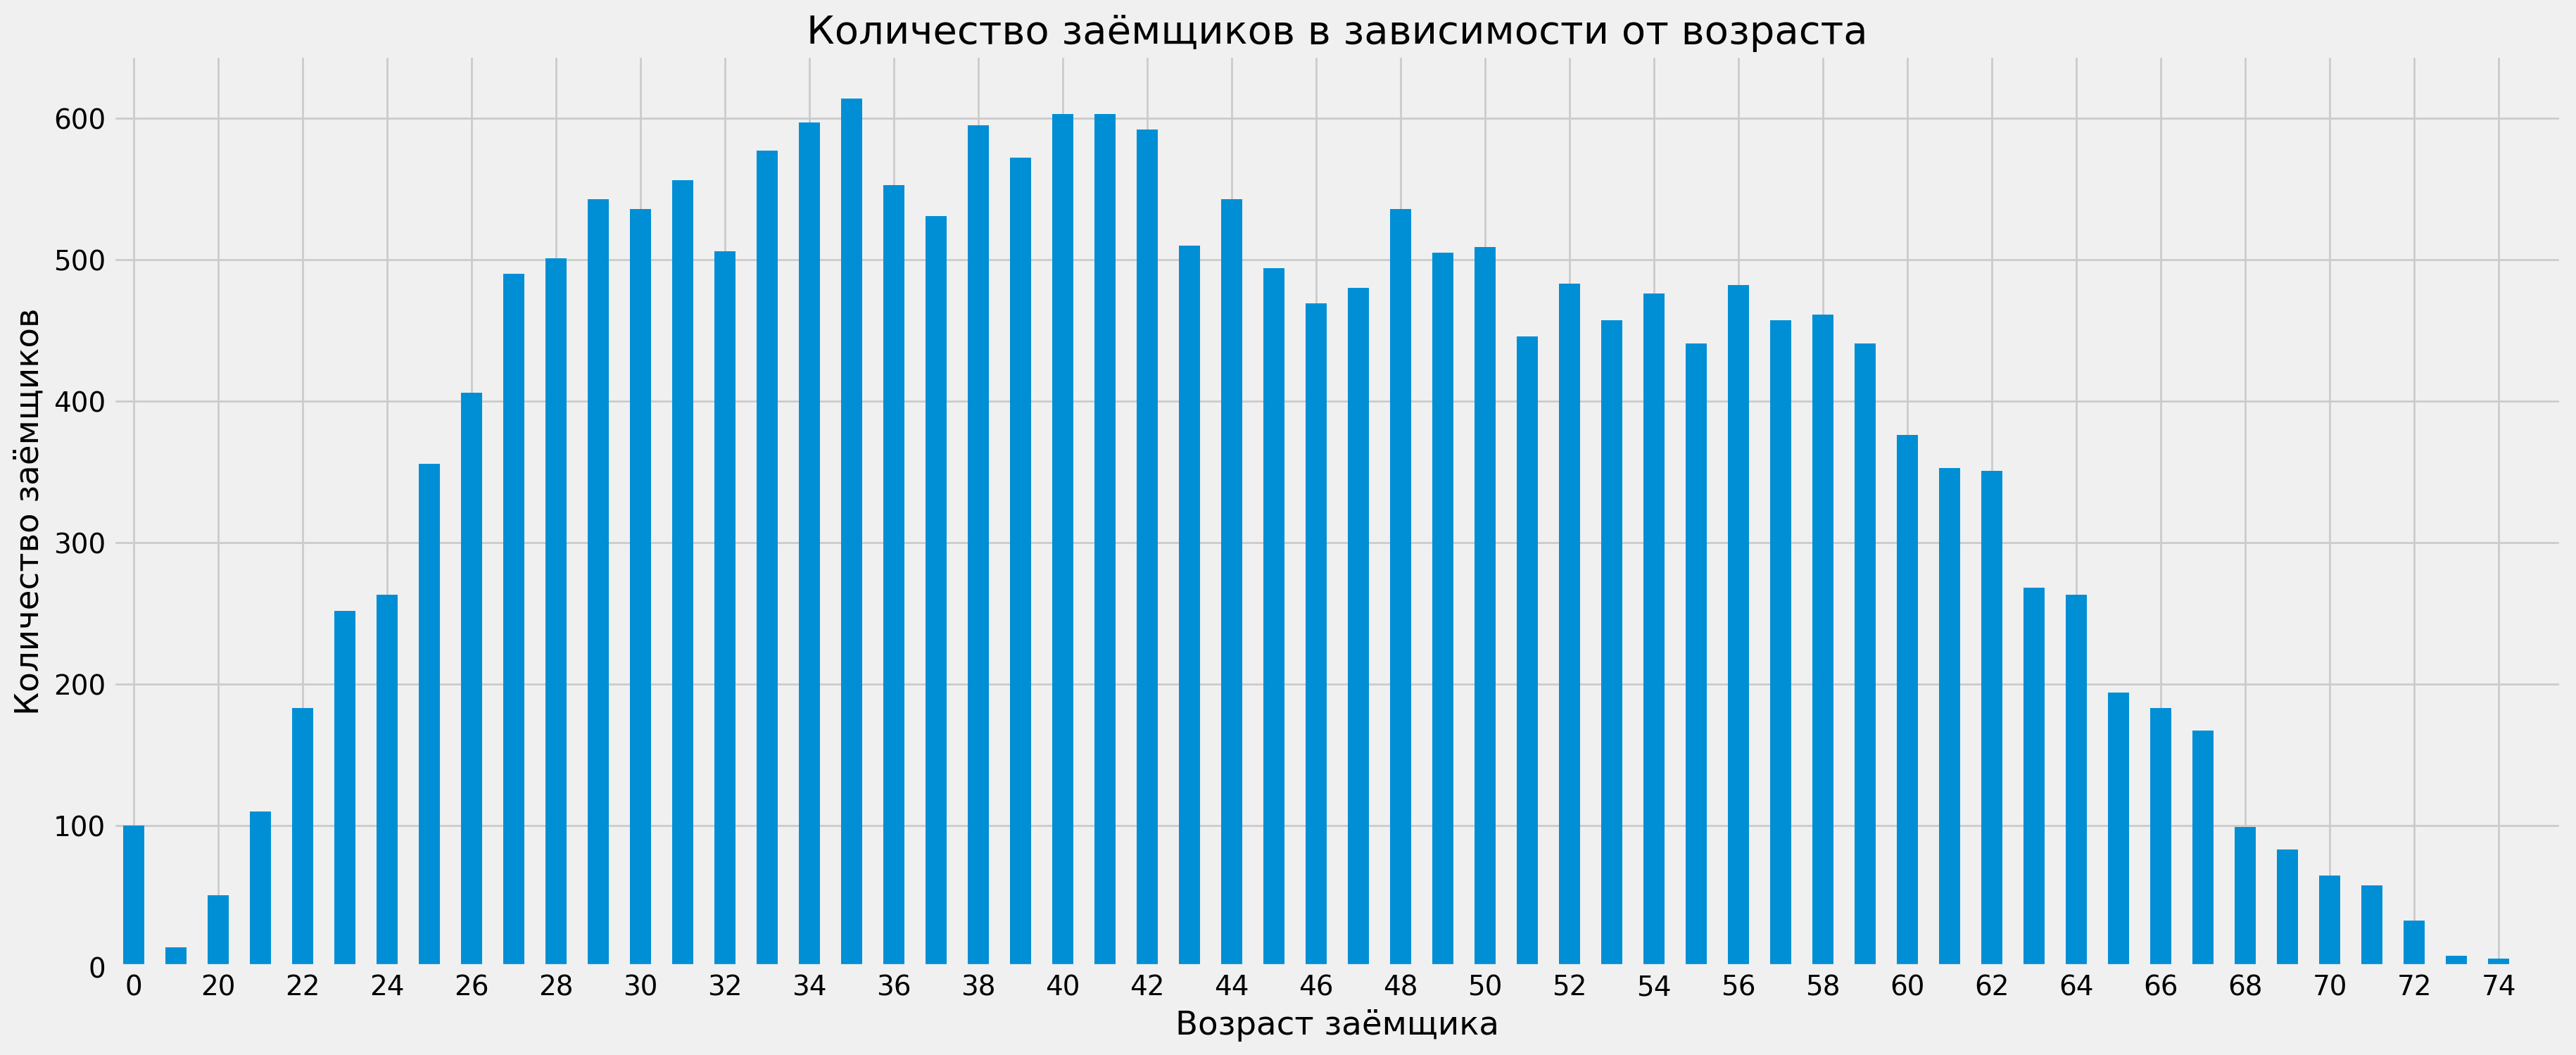

In [21]:
fig = bar_plot(table_pivot(credit, 'dob_years', 'dob_years', 'count'), 'dob_years')
plt.xticks(rotation=0)
plt.xticks(plt.xticks()[0][::2])
plt.xlabel('Возраст заёмщика')
plt.ylabel('Количество заёмщиков')
plt.title('Количество заёмщиков в зависимости от возраста')
plt.show;

В целом, возраст заёмщиков варьируется от 19 до 74 лет. Но при этом есть странные 100 заёмщиков с указанным возрастом 0. Это явно какая-то ошибка в данных. И таких заёмщиков можно удалить.

In [22]:
print('Процент данных с аномальным значением возраста заёмщика: ', 
      "{0:.1%}".format(credit.query('dob_years == 0')['dob_years'].count() / credit.shape[0]))

Процент данных с аномальным значением возраста заёмщика:  0.5%


In [23]:
credit = credit.query('dob_years != 0').reset_index(drop=True)
del_value[0] = credit.shape[0]

В других столбцах могут присуствовать дубликаты, а не аномалии.

In [24]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  1.0%


#### Промежуточные выводы:

- Были удалены аномалии из стобца с количеством детей.
- Были удалены аномалии из стобца с возрастом клиентов.
- Общее количество удалённых значений составило 1%.

### Изменение типов данных

Приведём типы данных в стобцах к правильным значениям.

In [25]:
credit.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Количество дней трудового стажа и зарплата должны быть целочисленными значениями. Обработка пропусков в этих столбцах была проведена, так что можно заменить тип данных на правильный.

In [26]:
credit['total_income'] = credit['total_income'].astype(int)
credit['days_employed'] = credit['days_employed'].astype(int)
credit['debt'] = credit['debt'].astype(bool)

In [27]:
credit.dtypes

children             int64
days_employed        int64
dob_years            int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                  bool
total_income         int64
purpose             object
dtype: object

### Обработка дубликатов

Посмотрим на уникальные значения в категориальных столбцах.

In [28]:
credit['education'] = credit['education'].str.lower()
credit['family_status'] = credit['family_status'].str.lower()
credit['purpose'] = credit['purpose'].str.lower()

In [29]:
print('Образование: ', credit['education'].unique())
print('Пол заёмщика: ', credit['gender'].unique())

Образование:  ['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
Пол заёмщика:  ['F' 'M' 'XNA']


В столбце с гендером заёмщика есть странное значение, посмотрим подробнее, сколько таких заёмщиков в данных.

In [30]:
table_pivot(credit, 'gender', 'gender', 'count')

,gender,total
0,F,14083
1,M,7218
2,XNA,1


Всего 1 заёмщик с неопределённым гендером. Скорее всего, это был пропуск от заёмщика, но так как мы не знаем пол человека и не можем сделать предположений из данных, то это значение можно удалить.

In [31]:
credit = credit.query('gender != "XNA"').reset_index(drop=True)
del_value[0] = credit.shape[0]

В таблице имелись 54 строчки с явными дубликатами. Посмотрим, сколько их на данный момент после исправлений регистра в стобцах. Их можно удалить из данных.

In [32]:
print('Количество явных дубликатов: ', credit.duplicated().sum())

Количество явных дубликатов:  71


In [33]:
credit = credit.drop_duplicates().reset_index(drop=True)
del_value[0] = credit.shape[0]

In [34]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  1.4%


### Категоризация данных

Выполним категоризацию дохода заёмщиков по следующему принципу:
- 0–30000 — `'F'`
- 30001–50000 — `'E'`
- 50001–100000 — `'D'`
- 100001–300000 — `'C'`
- 300001–1000000 — `'B'`
- 1000001 и выше — `'A'`.

In [35]:
credit['total_income_category'] = credit['total_income'].apply(categorize_income)

Категоризуем цель получения кредита на:
- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [36]:
credit['purpose_category'] = credit['purpose'].apply(categorize_purpose)

Получим общую информацию о данных. Убедимся, что предобработка выполнена успешно.

In [37]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21230 entries, 0 to 21229
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   children               21230 non-null  int64 
 1   days_employed          21230 non-null  int64 
 2   dob_years              21230 non-null  int64 
 3   education              21230 non-null  object
 4   education_id           21230 non-null  int64 
 5   family_status          21230 non-null  object
 6   family_status_id       21230 non-null  int64 
 7   gender                 21230 non-null  object
 8   income_type            21230 non-null  object
 9   debt                   21230 non-null  bool  
 10  total_income           21230 non-null  int64 
 11  purpose                21230 non-null  object
 12  total_income_category  21230 non-null  object
 13  purpose_category       21230 non-null  object
dtypes: bool(1), int64(6), object(7)
memory usage: 2.1+ MB


### Промежуточные выводы:

Была проведена предобработка данных для таблицы с заёмщиками:

- В таблице была 71 строчка явных дубликатов и пропуски значений в двух столбцах.
- Доля пропусков в двух столбцах занимала 10% от общего количества строк в датафрейме.
- Пропуски в столбце с суммой дохода и трудовым стажем заполнялись медианными значениями в зависимости от категории занятости.
- Аномалии в столбце с трудовым стажем были для двух категорий - безработных и пенсионеров. Аномалии были оставлены.
- Были удалены аномалии из стобца с количеством детей.
- Были удалены аномалии из стобца с возрастом клиентов.
- В столбце с гендером заёмщика находился 1 заёмщик с неопределённым гендером, он был удалён из данных.
- Удалённые данные составили 1.4% от всех данных в датафрейме.
- Была проведена категоризация суммы дохода клиентов, было создано 5 категорий.
- Была проведена категоризация цели получения клиентов, было создано 4 категории.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Семейное положение и возврат кредита в срок

In [38]:
debt(credit, 'family_status')

,family_status,total_credit,total_debt,share_debt
0,в разводе,1179,84,7.1%
1,вдовец / вдова,946,62,6.6%
2,гражданский брак,4112,383,9.3%
3,женат / замужем,12213,923,7.6%
4,не женат / не замужем,2780,272,9.8%


Женатые пары берут кредит гораздо чаще, чем остальные категории, и при этом процент должников среди них составляет 7.6%, что находится на третьем месте из пяти по показателям. Для людей в гражданском браке (берут кредит чаще, чем неженатые) процент должников составил уже 9.3%, а для неженатых - 9.8%. Меньше всего кредиты берут вдовцы и вдовы, и их количества достаточно для того, чтобы сделать выводы по группе. Также, из категории вдовцов лучше всего возвращают кредит: процент задолжавших составляет 6.6 %.

### Количество детей и возврат кредита в срок

Посмотрим на зависимость между количеством детей и возвратом кредита в срок.

In [39]:
debt(credit, 'children')

,children,total_credit,total_debt,share_debt
0,0,14021,1058,7.5%
1,1,4792,441,9.2%
2,2,2039,194,9.5%
3,3,328,27,8.2%
4,4,41,4,9.8%
5,5,9,0,0.0%


Семьи без детей гораздо чаще берут кредиты, чем семьи с детьми, и при этом находятся на первом месте по возврату кредита в срок. В этой группе всего 7.5% должников. Выборка семей с пятью детьми, которые не имеют долгов, не репрезентативна, так как таких семей всего 9 штук. Также семей с четырьмя детьми тоже крайне мало по отношению к остальным категориям, и при этом должников в этой группе больше всего - 9.8%. Можно отметить, что в семьях с детьми больше всего задолжности у тех, у кого 2 ребёнка - 9.5%, а меньше всего для заёмщиков с тремя детьми - 8.2%. 

### Возраст заёмщика и возврат кредита в срок

Так как диапазон возрастов заёмщиков весьма широк, поделим заёмщиков по возрастам на 6 примерно равных групп.

In [40]:
temp = credit.copy()
temp['age'] = pd.qcut(temp['dob_years'], q=6, precision=0)
debt(temp, 'age')

,age,total_credit,total_debt,share_debt
0,"(18.0, 30.0]",3698,403,10.9%
1,"(30.0, 36.0]",3397,335,9.9%
2,"(36.0, 43.0]",3997,341,8.5%
3,"(43.0, 50.0]",3524,265,7.5%
4,"(50.0, 57.0]",3229,203,6.3%
5,"(57.0, 75.0]",3385,177,5.2%


Люди из категории от 18 до 30 и от 57 до 75 реже берут кредиты, так как диапазон возрастов в этих группах около 12 лет, а для всех остальных групп - 7 лет. При этом можно отметить, что именно люди от 18 до 30 чаще бывают должниками - 10.9% задолжностей, а чем старше люди по возрасту, тем меньше процент должников.

### Пол заёмщика и возврат кредита в срок

In [41]:
debt(credit, 'gender')

,gender,total_credit,total_debt,share_debt
0,F,14021,984,7.0%
1,M,7209,740,10.3%


Женщины берут кредиты чаще чем мужчины почти в 2 раза, при том, что процент задолжностей у них 7%, в то время, как у мужчин - 10.3%.

#### Семейное положение для ж/м и возврат кредита в срок

In [42]:
debt(credit, ['gender', 'family_status'])

,gender,family_status,total_credit,total_debt,share_debt
0,F,в разводе,922,61,6.6%
1,F,вдовец / вдова,891,51,5.7%
2,F,гражданский брак,2816,231,8.2%
3,F,женат / замужем,7677,523,6.8%
4,F,не женат / не замужем,1715,118,6.9%
5,M,в разводе,257,23,8.9%
6,M,вдовец / вдова,55,11,20.0%
7,M,гражданский брак,1296,152,11.7%
8,M,женат / замужем,4536,400,8.8%
9,M,не женат / не замужем,1065,154,14.5%


Если посмотреть отдельно на женщин и мужчин и их семейный статус, то можно отметить, что наиболее рисковой категорией среди мужчин является категория неженатых с 14.5% должников. При этом женщины из этой категории имеют всего 6.9% должников, что не сильно выше замужних женщин с 6.8% должниками. А для мужчин женатых и неженатых очень большая разница в проценте должников.

### Уровень образования и возврат кредита в срок

In [43]:
debt(credit, 'education')

,education,total_credit,total_debt,share_debt
0,высшее,5192,277,5.3%
1,начальное,282,31,11.0%
2,неоконченное высшее,738,68,9.2%
3,среднее,15012,1348,9.0%
4,ученая степень,6,0,0.0%


Заёмщиков с учёной степенью практически нет, поэтому то, что они возвращают кредит в срок, не может являться релевантным значением. Можно отметить, что чаще берут кредиты люди со средним образованием, при этом задолжность у них составяет 9%. Хуже всего возвращают кредиты люди с начальным образованием, у них задолжность - 11%. Лучше всех возвращают кредиты люди с высшим образованием, это при том, что они находятся на втором месте по количеству взятых кредитов.

### Категория занятости заёмщика и возврат кредита в срок

In [44]:
debt(credit, 'income_type')

,income_type,total_credit,total_debt,share_debt
0,безработный,2,1,50.0%
1,в декрете,1,1,100.0%
2,госслужащий,1445,86,6.0%
3,компаньон,5026,373,7.4%
4,пенсионер,3792,215,5.7%
5,предприниматель,2,0,0.0%
6,сотрудник,10961,1048,9.6%
7,студент,1,0,0.0%


Релевантными категориями занятости заёмщиков являются только: сотрудник, компаньон, госслужащий и пенсионер. Во всех остальных группах единичные значения заёмщиков. При этом можно отметить, что группа сотрудников наиболее многочисленная, но и процент задолжности у них выше, чем в других релевантных группах - 9.6%. Самый низкий процент должников среди пенсионеров - всего 5.7%.

### Уровень дохода и возврат кредита в срок

In [45]:
debt(credit, 'total_income_category')

,total_income_category,total_credit,total_debt,share_debt
0,A,25,2,8.0%
1,B,503,29,5.8%
2,C,4484,324,7.2%
3,D,11797,1016,8.6%
4,E,4052,330,8.1%
5,F,347,21,6.1%
6,G,22,2,9.1%


Расшифровка категорий дохода:
- `А` - ежемесячный доход больше 1 млн
- `В` - ежемесячный доход от 400 тыс до 1 млн
- `С` - ежемесячный доход от 200 тыс до 400 тыс
- `D` - ежемесячный доход от 100 тыс до 200 тыс
- `Е` - ежемесячный доход от 50 тыс до 100 тыс
- `F` - ежемесячный доход от 30 тыс до 50 тыс
- `G` - ежемесячный доход меньше 30 тыс

Заёмщиков, которые получают меньше 30 тыс или больше 1 млн крайне мало по отношению к другим категориям - меньше 30. Поэтому то, что для этих категорий есть по 2 должника, не является релевантным значением. Зато можно отметить категорию с доходом от 100 до 200 тыс, которые чаще остальных берут кредиты и имеют самый высокий процент должников - 8.6%. Заёмщики с категорией дохода от 400 тыс до 1 млн рублей имеют самый низкий процент задолжностей - 5.8%.

Посмотрим, как поменяются значения, если попробовать разбить выборку на более-менее равные доли по кредиторам.

In [46]:
temp = credit.copy()
temp['income'] = pd.qcut(temp['total_income'], q=6, precision=0)
debt(temp, 'income')

,income,total_credit,total_debt,share_debt
0,"(20666.0, 92120.0]",3539,284,8.0%
1,"(92120.0, 119260.0]",3538,293,8.3%
2,"(119260.0, 142594.0]",3653,326,8.9%
3,"(142594.0, 172357.0]",3553,298,8.4%
4,"(172357.0, 228887.0]",3408,275,8.1%
5,"(228887.0, 2265604.0]",3539,248,7.0%


Теперь видно, что наибольше всего рисков приходится на категорию с доходом от 119 тыс до 142 тыс в месяц - 8.9% должников. Но при этом по другим группам процент должников не сильно ниже - от 8 до 8.4%. Самый маленький процент задолжностей по кредитам у группы с доходом от 229 тыс до 2.3 млн. Также можно отметить, что эта группа имеет самый широкий диапазон по получаемому доходу.

### Цели кредита и возврат кредита в срок

In [47]:
debt(credit, 'purpose_category')

,purpose_category,total_credit,total_debt,share_debt
0,операции с автомобилем,4258,397,9.3%
1,операции с недвижимостью,10703,777,7.3%
2,получение образования,3970,369,9.3%
3,проведение свадьбы,2299,181,7.9%


Заёмщики, которые берут кредиты на операции с недвижимостью, составляют самую большую группу, и при этом имеют один из самых низких показателей задолжностей - 7.3%. Кредит на проведение свадьбы берут реже всего, и также имеют по нему одну из самых низких показателей задолжности - 7.9%. Больше всего рисков приходится на операции с автомобилем и получение образование, так как кредиторов по этим группам достаточно много, и при этом высокий процент задолжностей - 9.3%.

## Итоги исследования

Была проанализирована статистика о платёжеспособности клиентов, предоставленная кредитным отделом банка. 

Перед анализом, данные были подготовлены для корректной работы:
- В таблице содержалось 11 столбцов и 21525 записей с информацией о заёмщиках.
- В двух столбцах были пропуски значений, доля пропусков составляла 10%.
- Пропуски в столбце с суммой дохода и трудовым стажем заполнялись медианными значениями в зависимости от категории занятости.
- Аномалии в столбце с трудовым стажем были для двух категорий - безработных и пенсионеров. Аномалии были оставлены.
- Были удалены аномалии из стобца с количеством детей.
- Были удалены аномалии из стобца с возрастом клиентов.
- В столбце с гендером заёмщика находился 1 заёмщик с неопределённым гендером, он был удалён из данных. 
- В таблице была 71 строчка явных дубликатов, они были удалены из таблицы.
- Процент удалённых значений составил 1.4% от данных датафрейма.
- Была проведена категоризация суммы дохода клиентов, было создано 5 категорий.
- Была проведена категоризация цели получения клиентов, было создано 5 категорий.

Были изучены разные показатели клиентов и влияния этих показателей на возврат кредита в срок:
1. Семейный статус:
    - Женатые пары берут кредит гораздо чаще, чем остальные категории
    - Процент должников среди женатых пар находится на третьем месте по показателям и составляет 7.6%
    - Процент должников для людей в гражданском браке составляет 9.3%
    - Наиболее рисковая группа - неженатые люди, процент должников для них 9.8%
    - Вдовствующие люди берут кредит реже всего и процент должников среди них самый низкий - 6.6%
2. Количество детей:
    - Семьи без детей берут кредит гораздо чаще, чем семьи с детьми
    - Процент должников среди семей без детей находится на первом месте по показателям и составляет 7.5%
    - Процент должников для семей с 3 детьми составляет 8.2%
    - Наиболее рисковые группы - семьи с 1 и 2 детьми, процент должников для них 9.2% и 9.5%, соответственно
3. Возраст заёмщика:
    - Люди из категорий от 18 до 30 и от 57 до 75 реже берут кредиты, так как диапазон возрастов в этих группах около 12 лет, а для всех остальных групп - 7 лет
    - Категория от 18 до 30 наиболее рисковая, процент должников для них составляет 10.9%
    - Второй по рисковости является группа людей от 30 до 36 лет - процент должников для них 9.9%
    - Чем старше возраст заёмщика, тем меньше процент должников по возрастной группе
4. Пол заёмщика:
   - Женщины берут кредиты чаще чем мужчины почти в 2 раза, при том, что процент задолжностей у них 7%, в то время, как у мужчин - 10.3%
   - Процент должников для замужних и незамужних женщин близок между собой и составляет 6.8% и 6.9%, соответственно
   - Для женатых и неженатых мужчин процент должников сильно отличается: 8.8% женатых мужчин являются должниками, в то время как 14.5% неженатых мужчин являются должниками
   - Рисковыми группами являются люди в гражданском браке: для женщин доля должников составляет 8.2%, для мужчин - 11.7%
6. Степень образования заёмщика:
   - Чаще всего берут кредиты люди со средним образованием
   - Процент должников для людей со средним образованием составляет 9%
   - Наиболее рисковые группы - люди с неоконченным высшим и с начальным образованием, процент должников для них 9.2% и 11%, соответственно
   - Лучше всех возвращают кредиты люди с высшим образованием - 5.3% должников, при том, что они находятся на втором месте по количеству взятых кредитов
7. Категория занятости:
   - Релевантными группами заёмщиков являются: сотрудник, компаньон, госслужащий и пенсионер
   - Сотрудники чаще берут кредит, чем остальные по категории занятости группы
   - Процент задолжности для сотрудников выше, чем для других релевантных групп и составляет 9.6%
   - Самый низкий процент должников среди пенсионеров - всего 5.7%
8. Уровень дохода:
   - Самая рисковая категория с доходом от 119 тыс до 142 тыс в месяц с 8.9% должников
   - Самый маленький процент задолжностей по кредитам у группы с доходом от 229 тыс до 2 млн 265 тыс, эта группа имеет самый широкий диапазон по получаемому доходу
9. Цели кредита:
    - Самая большая группа заёмщиков в категории с операциями на недвижимость
    - Самый маленький процент задолжностей для категории недвижимости - 7.3%
    - Кредит на проведение свадьбы берут реже всего и также имеют по нему один из самых низких показателей задолжности - 7.9%
    - Больше всего рисков приходится на операции с автомобилем и получения образования - 9.3% задолжностей

Можно подвести общий итог. Наиболее рисковыми категориями заёмщиков являются: 
- Люди в гражданском браке и неженатые (9.3% и 9.8%, соответственно)
- Люди с 1 и 2 детьми (9.2% и 9.5%, соотвественно)
- Люди по возрасту от 18 до 36 лет (от 9.9% до 10.9%)
- Мужчины (10.3%), причём неженатые мужчины (14.5%) и в гражданском браке (11.7%)
- Люди с любым образованием, кроме высшего и учёной степени (выше 9%)
- По категории занятости - сотрудники (9.6%)
- С уровнем дохода от 119 тыс до 143 тыс ежемесячно (8.9%)
- По целям кредита на операции с автомобилем и на образование (по 9.3%).